In [1]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# === SAM Module ===
class SAM(nn.Module):
    def __init__(self, channels):
        super(SAM, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        scale = torch.cat([avg_out, max_out], dim=1)
        scale = self.conv1(scale)
        scale = self.bn1(scale)
        scale = self.sigmoid(scale)
        return x * scale

# === MobileViT v2 with SAM ===
class MobileViTv2_SAM(nn.Module):
    def __init__(self, num_classes):
        super(MobileViTv2_SAM, self).__init__()
        self.backbone = timm.create_model('mobilevitv2_050', pretrained=True, num_classes=num_classes)
        self.sam1 = SAM(channels=64)
        self.sam2 = SAM(channels=128)

    def forward(self, x):
        x = self.backbone.forward_features(x)
        # Optional: add SAM at extracted features if needed
        # x = self.sam1(x)
        x = self.backbone.head(x)
        return x

# === Dataset Preparation ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

base_path = '/home/itartoussi/.agml/datasets/dataset_occluded_tomato10'
train_dataset = datasets.ImageFolder(os.path.join(base_path, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(base_path, 'val'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes

# === Training Setup ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MobileViTv2_SAM(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("✅ MobileViTv2 + SAM model is ready for training.")


/home/itartoussi/miniconda3/envs/agml_env_312/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/itartoussi/miniconda3/envs/agml_env_312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ MobileViTv2 + SAM model is ready for training.


In [4]:
from sklearn.metrics import classification_report, f1_score
import numpy as np
import torch

num_epochs = 100
best_f1 = 0.0
save_path = 'best_model_sam.pth'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # === Validation ===
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    val_acc = np.mean(np.array(val_preds) == np.array(val_labels))
    print(f"Epoch {epoch+1:>3}/{num_epochs}, Loss: {running_loss:.4f}, Val Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), save_path)
        print(f"✅ Best model saved at epoch {epoch+1} with F1-score: {val_f1:.4f}")


Epoch   1/100, Loss: 690.0142, Val Acc: 0.8729, F1: 0.8488
✅ Best model saved at epoch 1 with F1-score: 0.8488
Epoch   2/100, Loss: 174.6875, Val Acc: 0.9771, F1: 0.9770
✅ Best model saved at epoch 2 with F1-score: 0.9770
Epoch   3/100, Loss: 81.5578, Val Acc: 0.9874, F1: 0.9874
✅ Best model saved at epoch 3 with F1-score: 0.9874
Epoch   4/100, Loss: 49.4683, Val Acc: 0.9940, F1: 0.9939
✅ Best model saved at epoch 4 with F1-score: 0.9939
Epoch   5/100, Loss: 36.3980, Val Acc: 0.9951, F1: 0.9951
✅ Best model saved at epoch 5 with F1-score: 0.9951
Epoch   6/100, Loss: 24.9536, Val Acc: 0.9980, F1: 0.9980
✅ Best model saved at epoch 6 with F1-score: 0.9980
Epoch   7/100, Loss: 20.9772, Val Acc: 0.9980, F1: 0.9980
Epoch   8/100, Loss: 15.1344, Val Acc: 0.9980, F1: 0.9980
✅ Best model saved at epoch 8 with F1-score: 0.9980
Epoch   9/100, Loss: 14.2501, Val Acc: 0.9993, F1: 0.9993
✅ Best model saved at epoch 9 with F1-score: 0.9993
Epoch  10/100, Loss: 11.3981, Val Acc: 0.9996, F1: 0.9996
✅ 

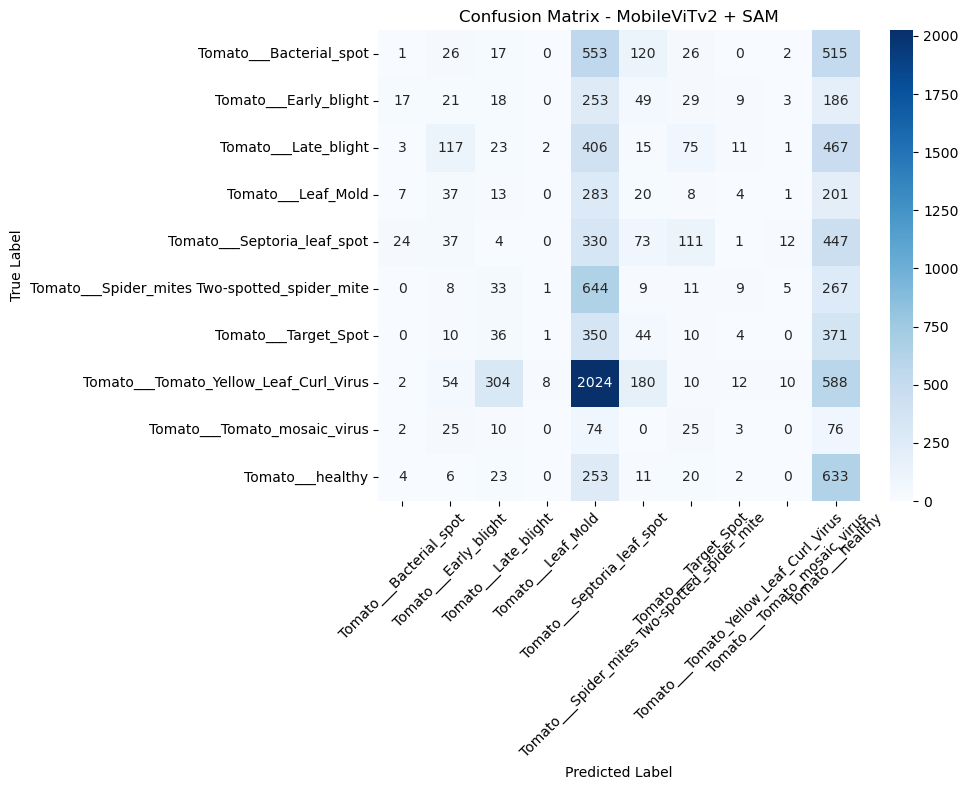

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# === Compute Predictions on Validation Set ===
model.eval()
val_preds = []
val_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# === Compute Confusion Matrix ===
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - MobileViTv2 + SAM')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [3]:
from torchcam.methods import GradCAM
from torchvision.transforms.functional import normalize, resize
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# Attach GradCAM to your model
cam_extractor = GradCAM(model, target_layer="backbone.conv_head")  
img_tensor, label = val_dataset[0]
input_tensor = img_tensor.unsqueeze(0).to(device)

# Enable evaluation mode
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    pred_class = output.argmax().item()

# Generate CAM
activation_map = cam_extractor(pred_class, output)

# Convert CAM to numpy
activation = activation_map[0].squeeze().cpu().numpy()

# Prepare original image
img_np = np.transpose(img_tensor.numpy(), (1, 2, 0))  # C x H x W → H x W x C
img_np = np.clip(img_np, 0, 1)

# Resize activation map to image size
activation_resized = resize(torch.tensor(activation), img_np.shape[:2], antialias=True).numpy()

# Overlay heatmap
plt.figure(figsize=(6, 6))
plt.imshow(img_np)
plt.imshow(activation_resized, cmap='jet', alpha=0.5)
plt.title(f"Grad-CAM for predicted class: {class_names[pred_class]}")
plt.axis('off')
plt.tight_layout()
plt.show()


ValueError: Unable to find all submodules ['backbone.conv_head'] in the model

In [ ]:
pip install scikit-learn matplotlib


Extracting Features: 100%|██████████| 336/336 [00:30<00:00, 11.06it/s]
/home/itartoussi/miniconda3/envs/agml_env_312/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


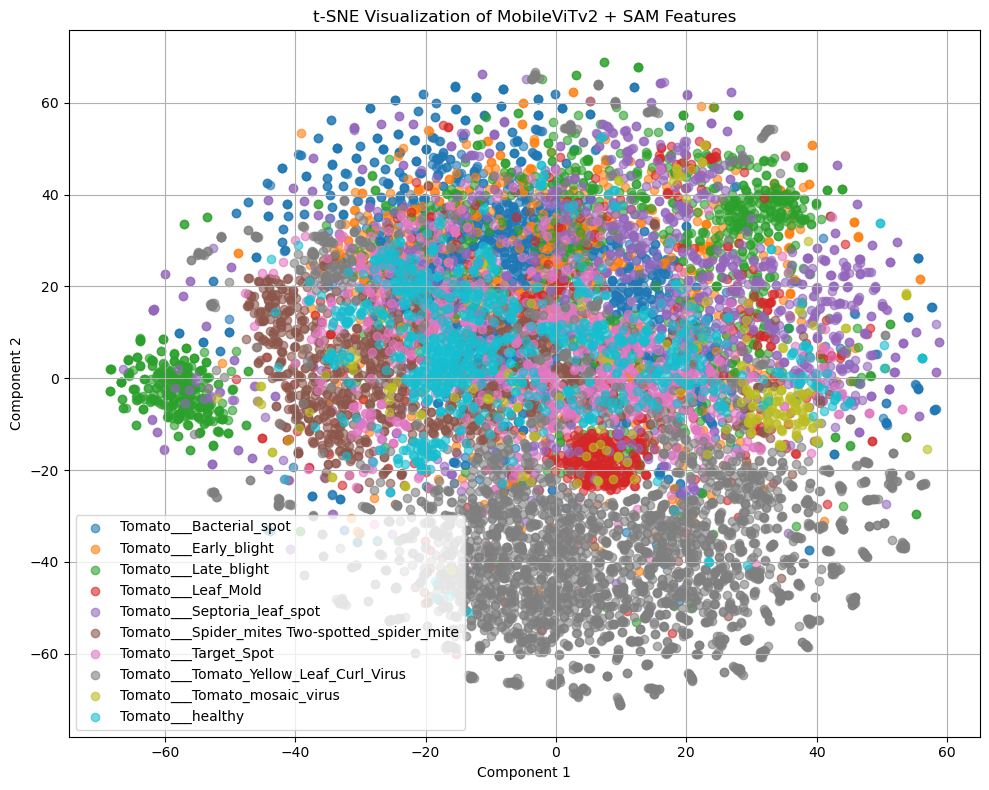

✅ t-SNE plot saved as: tsne_mobilevitv2_sam.png


In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
import os

# === استخراج الميزات ===
model.eval()
features = []
labels = []

with torch.no_grad():
    for inputs, targets in tqdm(val_loader, desc="Extracting Features"):
        inputs = inputs.to(device)
        outputs = model.backbone.forward_features(inputs)
        outputs = torch.flatten(outputs, 1)
        features.append(outputs.cpu().numpy())
        labels.extend(targets.cpu().numpy())

features = np.concatenate(features, axis=0)
labels = np.array(labels)

# === تقليل الأبعاد باستخدام t-SNE ===
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(features)

# === رسم t-SNE وحفظ الصورة ===
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    idxs = labels == i
    plt.scatter(tsne_results[idxs, 0], tsne_results[idxs, 1], label=class_names[i], alpha=0.6)

plt.legend()
plt.title("t-SNE Visualization of MobileViTv2 + SAM Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()

# حفظ الصورة
save_path = "tsne_mobilevitv2_sam.png"
plt.savefig(save_path, dpi=300)
plt.show()

print(f"✅ t-SNE plot saved as: {save_path}")
